In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageSequence

DATA_PATH = '/kaggle/input/medical-image-processing-2d-segmentation/'
OUT_PATH = '/kaggle/working/'

def load_from_multi_page_tiff(path_to_image):
    image_np_array_list = []
    image_with_multi_page = Image.open(path_to_image)
    for idx, page_image in enumerate(ImageSequence.Iterator(image_with_multi_page)):
        image_np_array_list.append(np.array(page_image))
    return np.stack(image_np_array_list)

def load_from_single_page_tiff(path_to_image):
    return np.array(Image.open(path_to_image))

def get_image_shape(np_array):
    if isinstance(np_array, (np.ndarray, np.generic)):
        print("Loaded data shape: {}".format(np_array.shape))
    else:
        print('Input type error!')

def seek_file_in_folder(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

def parsing_cell_tracking_data(ground_truth_path):
    x_image_array, y_image_array = [], []
    for folder in ground_truth_path:
        image_name_list = seek_file_in_folder(DATA_PATH + folder + '/SEG/')
        seg_image_dict = dict()
        for image_name in image_name_list:
            name = image_name[-7:]
            if '.txt' in name : continue
            seg_image_dict[name] = load_from_single_page_tiff(image_name)
        image_name_list_1 = seek_file_in_folder(DATA_PATH + folder[:-3])
        x_image, y_image = [], []
        for img_name, img_array in seg_image_dict.items():
            matching = [s for s in image_name_list_1 if img_name in s]
            x_image.append(load_from_single_page_tiff(matching[0]))
            y_image.append(img_array)
        x_image_array += x_image
        y_image_array += y_image
    return np.stack(x_image_array), np.stack(y_image_array)

def overlap_tile_processing(img_array, expend_px_width, expend_px_height):
    def flip_horizontally(np_array):
        return cv2.flip(np_array, 1)

    def flip_vertically(np_array):
        return cv2.flip(np_array, 0)

    original_height = img_array.shape[0]
    original_width = img_array.shape[1]

    # Expand width first
    # left:
    left_result = flip_horizontally(img_array[0:0 + original_height, 0:0 + expend_px_width])
    # right:
    right_result = flip_horizontally(
        img_array[0:0 + original_height, original_width - expend_px_width: original_width])

    result_img = cv2.hconcat([left_result, img_array])
    result_img = cv2.hconcat([result_img, right_result])

    result_img_height = result_img.shape[0]
    result_img_width = result_img.shape[1]

    # Expand height
    top_result = flip_vertically(result_img[0:0 + expend_px_height, 0:0 + result_img_width])
    bottom_result = flip_vertically(
        result_img[result_img_height - expend_px_height: result_img_height, 0:0 + result_img_width])

    result_img = cv2.vconcat([top_result, result_img])
    result_img = cv2.vconcat([result_img, bottom_result])

    return result_img

def convert_to_datagen_format(py_list):
    nparray = np.array(py_list)
    return nparray.reshape(nparray.shape + (1,))

def data_generator(x, batch_size=10, epoch=50, seed=2003):
    data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=30,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')
    datagen = ImageDataGenerator(**data_gen_args)
    datagen_generator = datagen.flow(x, batch_size=batch_size, seed=seed)
    tmp_x, i = list(), 0
    for batch_x in datagen_generator:
        tmp_x += list(batch_x)
        i += 1
        if i >= epoch: 
            return np.array(tmp_x)

def split_image2_4patch(imgs):
    ret = list()
    for x in imgs:
        ret.append(x[0:572, 0:572, :].copy())
        ret.append(x[0:572, 124:696, :].copy())
        ret.append(x[124:696, 0:572, :].copy())
        ret.append(x[124:696, 124:696, :].copy())
    return np.array(ret)

In [12]:
def get_ISBI_2012_dataset():
    """
    Loading from ISBI dataset and convert to two image array (raw_data & ground_truth)
    :return: np_array, np_array
    """
    x_image_array = load_from_multi_page_tiff(path_to_image=DATA_PATH + 'ISBI2012/train-volume.tif')
    y_image_array = load_from_multi_page_tiff(path_to_image=DATA_PATH + 'ISBI2012/train-labels.tif')
    get_image_shape(x_image_array)
    x = np.array(x_image_array, dtype = np.float32) / 255
    y = np.array(y_image_array, dtype = np.float32) / 255
    return x, y

def get_DIC_C2DH_HeLa():
    """
    get DIC C2DH HeLa dataset where had ground truth data only
    :return: x_np_array, y_np_array
    """
    folder_path_list = ['PhC-C2DH-U373/01_GT', 'PhC-C2DH-U373/02_GT']
    x, y = parsing_cell_tracking_data(folder_path_list)
    get_image_shape(x)
    y[y > 0] = 255
    x = np.array(x, dtype = np.float32) / 255
    y = np.array(y, dtype = np.float32) / 255
    return x, y

def get_PhC_C2DH_U373():
    """
    get PhC C2DH U373 dataset where had ground truth data only
    :return: x_np_array, y_np_array
    """
    folder_path_list = ['DIC-C2DH-HeLa/01_GT', 'DIC-C2DH-HeLa/02_GT']
    x, y = parsing_cell_tracking_data(folder_path_list)
    get_image_shape(x)
    y[y > 0] = 255
    x = np.array(x, dtype = np.float32) / 255
    y = np.array(y, dtype = np.float32) / 255
    return x, y

In [27]:
# weight maps for binary masks
import scipy.ndimage as ndi
def weight_map(img, w0=10, sigma=5):
    """
    Create a UNet weight map from a boolean `mask` where `True`
    marks the interior pixels of an instance.
    """
    mask = np.array(img, dtype=np.int32)
    # if the mask only has one contiguous class,
    # then there isn't much to do.
    if len(np.unique(mask)) == 1:
        return np.ones(mask.shape, dtype=np.float32) * 0.5

    # calculate the class-balanced weight map w_c
    w_c = np.zeros(mask.shape, dtype=np.float32)
    w_1 = 1 - float(np.count_nonzero(mask)) / w_c.size
    w_0 = 1 - w_1
    w_c[mask > 0.5] = w_1
    w_c[mask < 0.5] = w_0

    # calculate the distance-weighted emphases w_e
    segs, _ = ndi.label(mask)
    if segs.max() == 1:
        # if there is only 1 instance plus background,
        # then there are no separations
        print("hello")
        return w_c
    ilabels = range(1, segs.max()+1)
    distmaps = np.stack([ndi.distance_transform_edt(segs != l) for l in ilabels])
    distmaps = np.sort(distmaps, axis=0)[:2]
    w_e = w0 * np.exp((-1 * (distmaps[0] + distmaps[1]) ** 2) / (2 * (sigma ** 2)))
    w_e[mask] = 0.
    return w_c + w_e

def get_weight_maps(data):
    weight_maps = []
    print('Starting...')
    for i, img in enumerate(data):
        cur = weight_map(img)
        weight_maps.append(cur)
        if (i + 1) % 15 == 0 : 
            print(i + 1)
        else : 
            print(i + 1, end=' ')
    print('Done!')
    return weight_maps

In [4]:
def visualize_pred(x, y_true, y_pred, title1="Original", title2="True", title3="Predicted", cmap='gray'):
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    ax = plt.subplot("131")
    ax.set_title(title1)
    ax.imshow(np.squeeze(x), cmap=cmap)

    ax = plt.subplot("132")
    ax.set_title(title2)
    ax.imshow(np.squeeze(y_true), cmap=cmap)
    
    ax = plt.subplot("133")
    ax.set_title(title3)
    ax.imshow(np.squeeze(y_pred), cmap=cmap)

    plt.show()

In [32]:
# DATA for everything
cur = 'U373'

def name(s):
    return OUT_PATH + str(s) + '_' + cur + '.npy'

def get_data():
    if cur == 'ISBI' : return get_ISBI_2012_dataset()
    if cur == 'HeLa' : return get_DIC_C2DH_HeLa()
    if cur == 'U373' : return get_PhC_C2DH_U373()
    print('Wrong name specified')

def delete():
    os.remove(name('X'))
    os.remove(name('Y'))
    os.remove(name('W'))

X_0, Y_0 = get_data()
W_0 = get_weight_maps(Y_0)

Loaded data shape: (18, 512, 512)
Starting...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
16 17 18 Done!


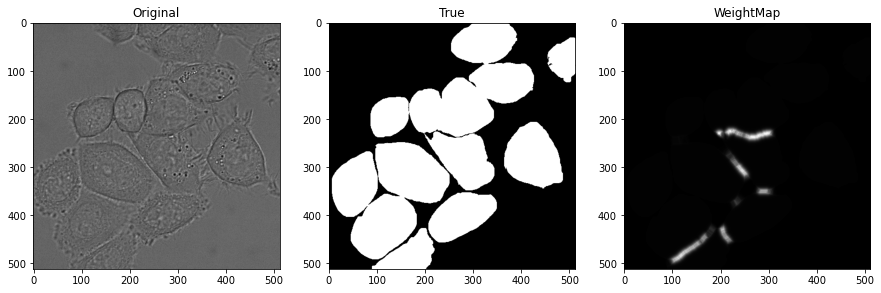

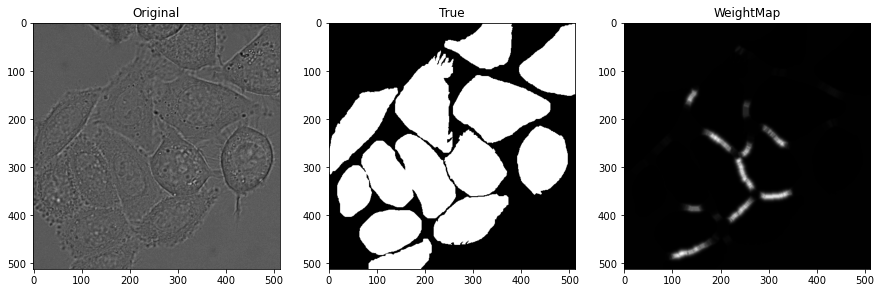

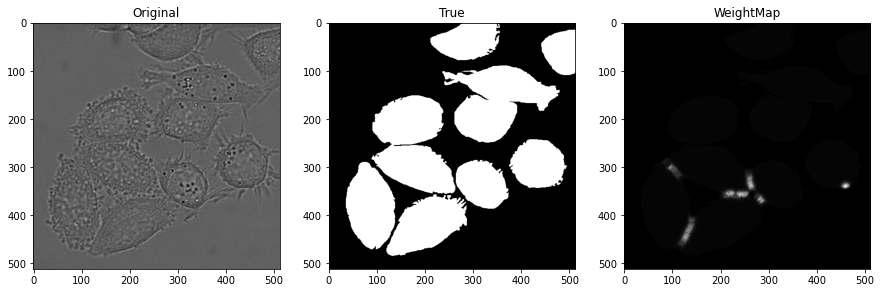

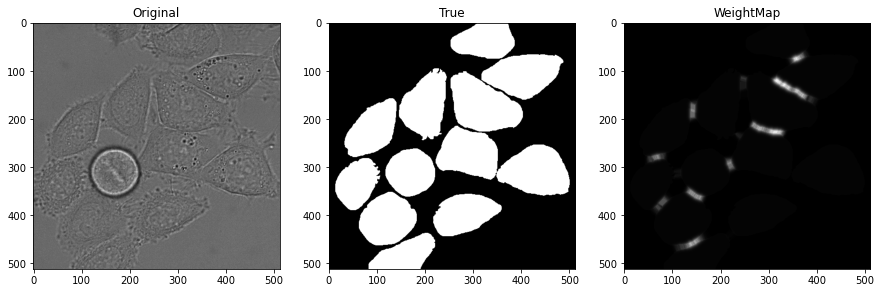

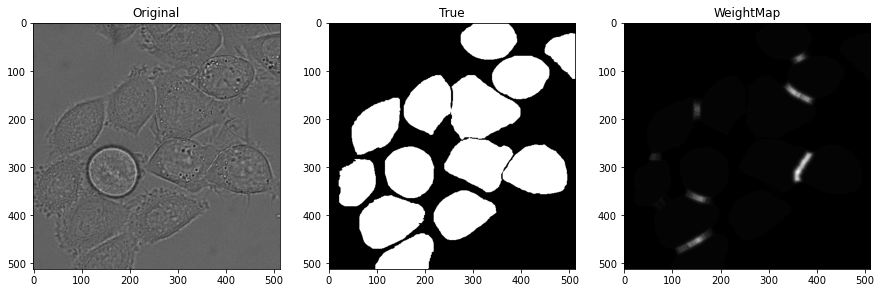

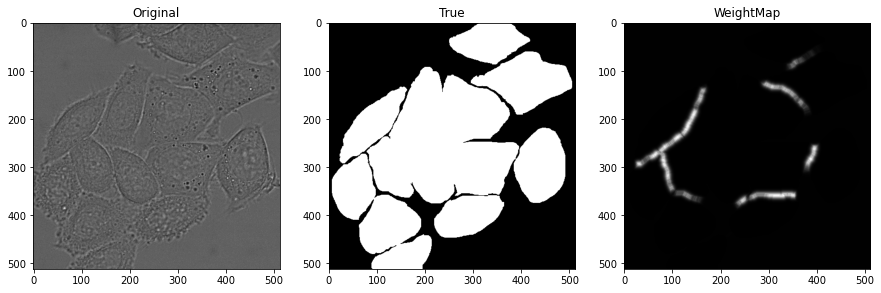

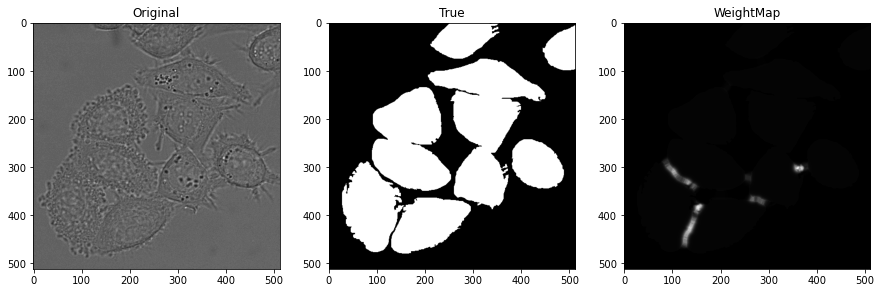

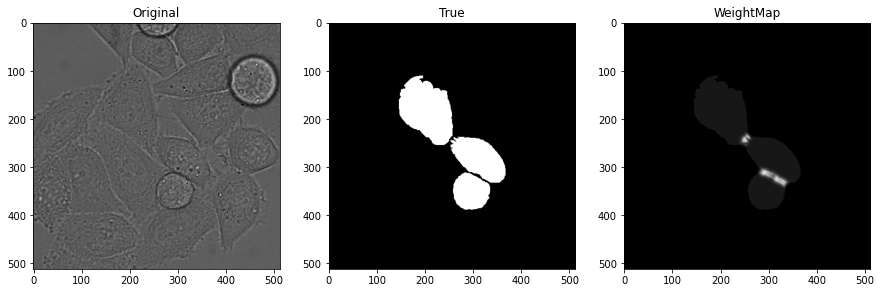

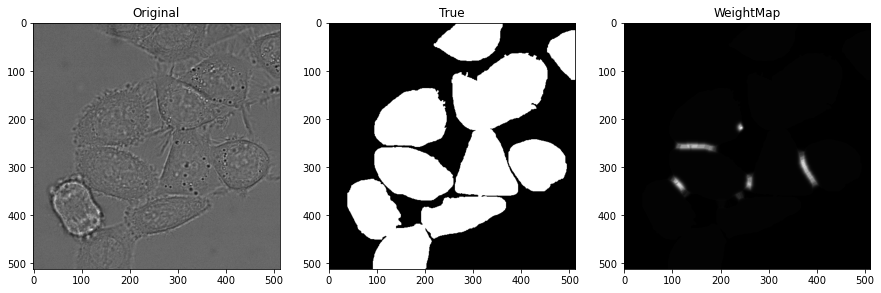

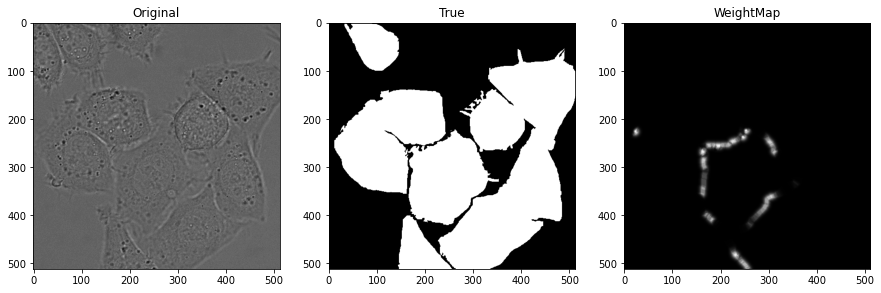

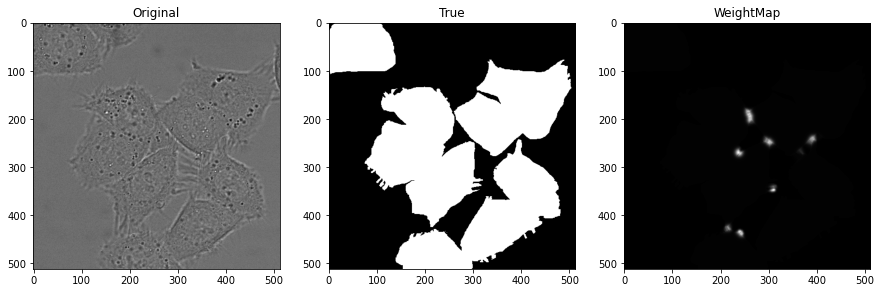

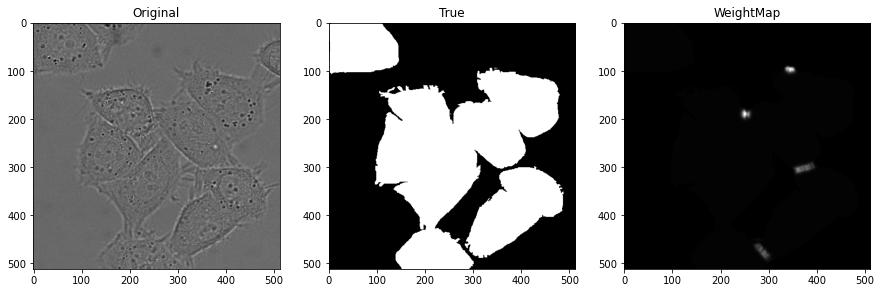

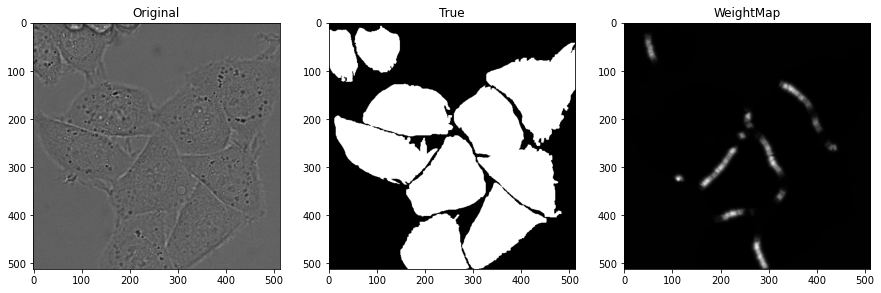

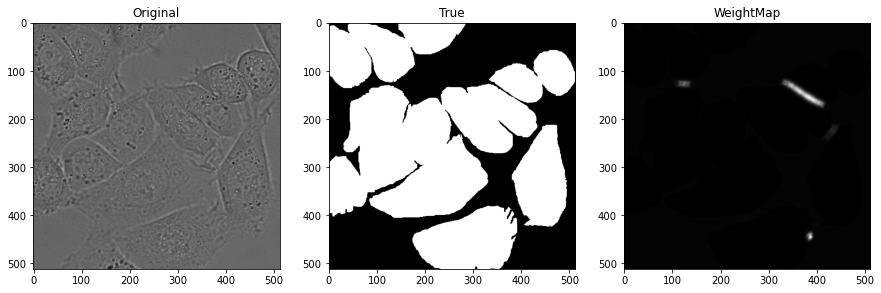

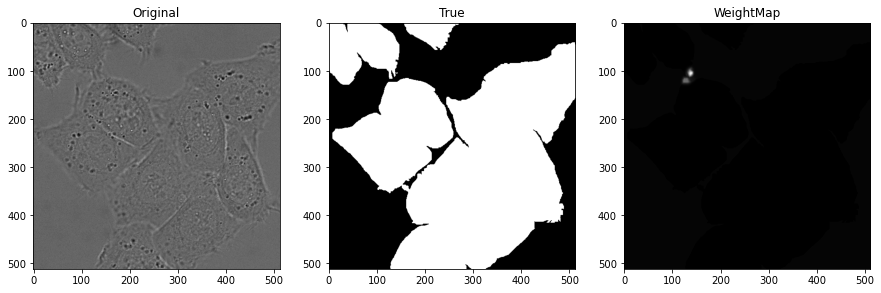

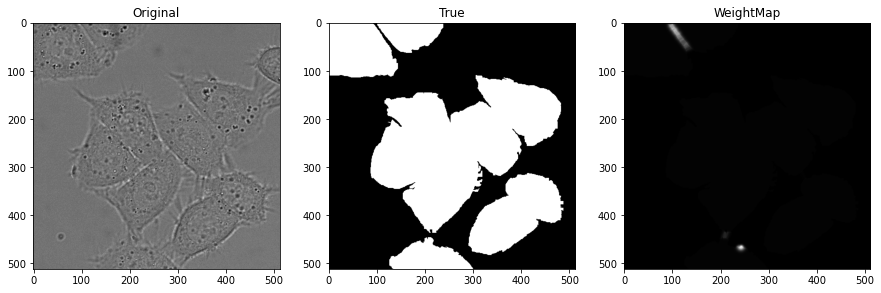

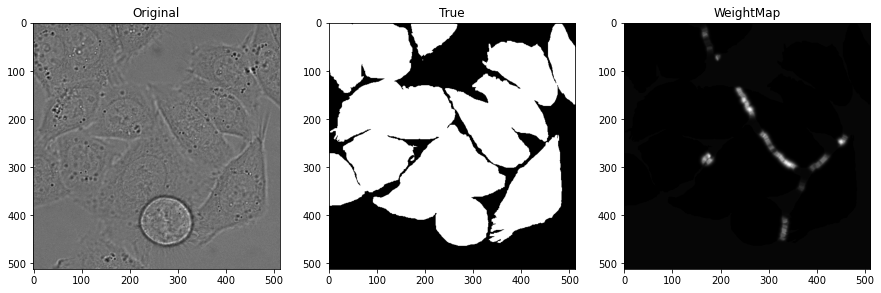

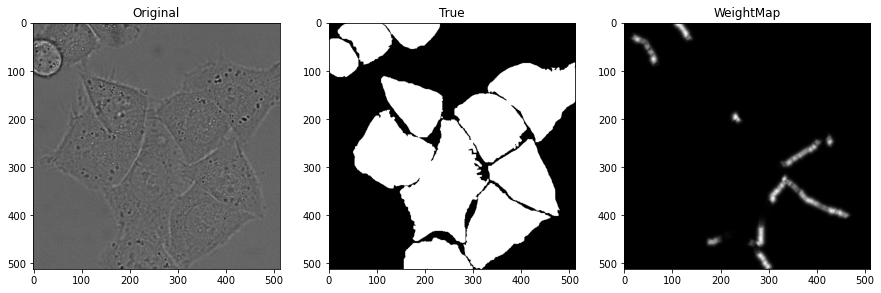

In [33]:
for index in range(X_0.shape[0]):
    xx, yy, ww = X_0[index], Y_0[index], W_0[index]
    visualize_pred(xx, yy, ww, title1="Original", title2="True", title3="WeightMap")

In [34]:
X_1 = convert_to_datagen_format(X_0)
Y_1 = convert_to_datagen_format(Y_0)
W_1 = convert_to_datagen_format(W_0)

X = data_generator(X_1, batch_size=10, epoch=100, seed=2003) 
Y = data_generator(Y_1, batch_size=10, epoch=100, seed=2003) 
W = data_generator(W_1, batch_size=10, epoch=100, seed=2003) 

print('Shape : {}'.format(X.shape))
np.save(name('X'), X)
np.save(name('Y'), Y)
np.save(name('W'), W)
print("Saved successfully")

Shape : (900, 512, 512, 1)


OSError: Not enough free space to write 943718400 bytes

In [ ]:
X = np.load(name('X'))
Y = np.load(name('Y'))
W = np.load(name('W'))
print('Shape : {}'.format(X.shape))
print("Loaded successfully")